# Free energy landscapes and clustering with Gaussian mixture models

## 1. Reading the data

In [1]:
import numpy as np
import GMM_FE

data = np.loadtxt('data/CaM_PCA_CA_contacts_REST.txt')


## 2. Constructing the object and setting parameters
Create a free energy and clustering object. In principle, *data*, minimum number of components, *min_n_components*, and maximum number of components, *max_n_components* need to be specified. If *max_n_components* is not specified, the free energy estimation and clustering will be done using *min_n_components* components. The settings of necessary parameters will be printed below.

In [9]:
gmm_FE = GMM_FE.FreeEnergy(data, min_n_components=10, max_n_components=20, temperature=300.0, 
                            n_iterations=3, n_grids=30)

*----------------Gaussian mixture model free energy estimator----------------*
   n_splits = 3
   shuffle_data = False
   n_iterations = 3
   n_grids = 30
   covergence_tol = 1e-06
   stack_landscapes = False
   x_lims (axes limits) = [[-4.8644411168558515, 10.83157794323054], [-6.875103988258936, 8.627237475799573]]
   temperature = 300.0
   min_n_components = 10
   max_n_components = 20
*----------------------------------------------------------------------------*


## 3. Estimating free energy landscapes

The density estimation is performed with Gaussian mixture models (GMM) and $K$-fold cross-validation. 

### Gaussian mixture model
A Gaussian mixture density is a weighted sum of Gaussian components, 
$$\rho(x) = \sum\limits_{i=1}^{N_{\text{basis}}} \pi_i \mathcal{N}(x|\; \mu_i,\; \Sigma_i),$$
where $\pi_i$ is the amplitude, $\mu_i$ is the mean and $\Sigma_i$ is the covariance of the $i$th Gaussian. The amplitudes, means and covariances are here optimized iteratively with Expectation-Maximization. The expectation-maximization algorithm consists of two steps, abbreviated E-step and the M-step.

#### - E-step
In the E-step, the responsibility of each data point with respect to the Gaussian components is calculated as
$$ \gamma_{ni} = \frac{\pi_i \mathcal{N}(x_n|\; \mu_i,\; \Sigma_i)}{\sum\limits_{i=1}^{N_{\text{basis}}} \pi_i \mathcal{N}(x_n|\; \mu_i,\; \Sigma_i)}.$$

#### - M-step
The parameters are then updated in the maximization step. The amplitudes are updated with
$$\pi_i = \frac{\sum_n \gamma_{ni}}{\sum_{n,i}\gamma_{ni}},$$
the means with
$$\mu_i = \frac{\sum_n \gamma_{ni}x_n}{\sum_n \gamma_{ni}},$$
and covariances with
$$\Sigma_i = \frac{\sum_n \gamma_{ni}(x_n-\mu_i)(x_n-\mu_i)^T}{\sum_n \gamma_{ni}} .$$

These two steps are carried out until convergence of the log-likelihood, $\mathcal{l} = \sum_{n=1}^N \log (\rho(x_n))$. 

### Model selection with $K$-fold cross-validation
To select the number of Gaussian components in the density model, we use a cross-validation scheme. The data is split into $K$ folds. In cross-validation, one chunk of the data is used for training model parameters, and the other is used for validating the trained model. In this case, model validation occurs by calculating the log-likelihood of the validation set. In $K$-fold cross-validation, each fold is used as a validation set once per model. This results in $K$ training and validation sets for each model. The total validation log-likelihood score of a model is the summed validation log-likelihoods of all validation sets.

### Estimating free energy landscapes with GMM_FE
Calling the function *landscape()* will estimate the density and free energy landscape with Gaussian mixture models and plot the landscape. The axes limits of the landscape are printed above. The number of folds in the cross-validation is set with the variable *n_splits*. Model selection is done in two ways depending on if *stacking_landscapes* is set to True or False.
<br>
> **If *stacking_landscapes* is set to False**:
> When *stacking_landscapes* is False, cross-validation will be used to pick the "best" number of GMM components based on the highest log-likelihood of the validation datasets. The final landscape will then be estimated using the full dataset with the "best" number of components.
<br>
**If *stacking_landscapes* is set to True**:
> When *stacking_landscapes* is True, all density models obtained with the training set will be stored. The final density model will be the weighted average of all models. The weights are calculated using the validation dataset. 

**This returns:**
1. *coords*: The coordinates of the grid that is used for visualization.
2. *FE_landscape*: The estimated free energy of each grid point.
3. *FE_points*: The estimated free energy of each point in *data*.

In [10]:
coords, FE_landscape, FE_points = gmm_FE.landscape()
print('Test set log-likelihood: '+str(gmm_FE.test_set_loglikelihood))

Estimating density with GMM.
# Components = 10
Summed validation set log-likelihood: -14.934488587001862
# Components = 11
Summed validation set log-likelihood: -14.748096315879762
# Components = 12
Summed validation set log-likelihood: -14.862342591194711
# Components = 13
Summed validation set log-likelihood: -14.433976636773085
# Components = 14
Summed validation set log-likelihood: -14.638441652521571
# Components = 15
Summed validation set log-likelihood: -14.70740585594396
# Components = 16
Summed validation set log-likelihood: -14.638761769866443
# Components = 17
Summed validation set log-likelihood: -14.68178024733379
# Components = 18
Summed validation set log-likelihood: -14.80509146507917
# Components = 19
Summed validation set log-likelihood: -14.871240384440192
# Components = 20
Summed validation set log-likelihood: -14.92221129359427
Training final model with 13 components.
Evaluating density in landscape
Density grid shape: (30, 30)
Test set log-likelihood: None


## 4. Visualizing the free energy landscape
To visualize the estimated free energy landscape, we call the *visualize* function. To visualize with the standard parameter settings, it is just to run 
<br>
> **gmm_FE.visualize()**

<br> However, you might want to change some of the parameters. 
<br><br>
**The following parameters can be changed:**
1. *title*: The title of the figure
2. *fontsize*: Title fontsize, other labels are changed according to this
3. *savefig*: True/False (whether to save a .png and .eps figure)
4. *xlabel*: The x-label
5. *ylabel*: The y-label
6. *vmax*: Colormap max cutoff value.
7. *n_contour_levels*: Determines the number and positions of the contour lines / regions in contourf.
8. *show_data*: True/False (whether to scatter-plot the original data and/or clustering)

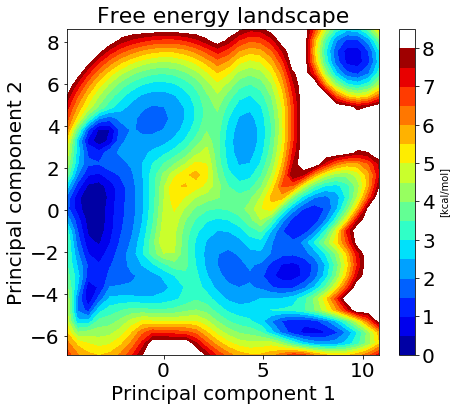

In [11]:
gmm_FE.visualize(savefig=False,vmax=8, n_contour_levels=18, xlabel='Principal component 1', ylabel='Principal component 2',show_data=False)

## 5. Cluster points at free energy minima
Clustering the free energy landscape can be done with 
<br> 
> **gmm_FE.cluster(data, FE_points)**

<br>Recall that *FE_points* is an array with the estimated free energy of each point in *data*. To make the clustering slightly more robust, we can do it over the grid that we use for visualization,
> **gmm_FE.cluster(grid_points, FE_points, data)**

The grid coordinates are kept in *coords*. In such case, we also need to parse *data* as a third argument to return the cluster labels and cluster center indices of the *data* points. 
<br> <br>
**This returns:**
1. *labels*: The cluster label/index of each point, denoting which cluster the point belongs to. If zero, the point is a transition point, otherwise it belongs to some intermediate state.
2. *cluster_centers*: Contains the indices corresponding to the point of each cluster that has the smallest free energy.
<br>

In [12]:
labels, cluster_centers = gmm_FE.cluster(coords,FE_points,data)

Clustering free energy landscape...
Computing Hessians.
Constructing connected components.
# Graph connections: 188.0
Clustering data points.
Cluster labels: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
Done clustering.


## 6. Visualize free energy landscape with identified clusters

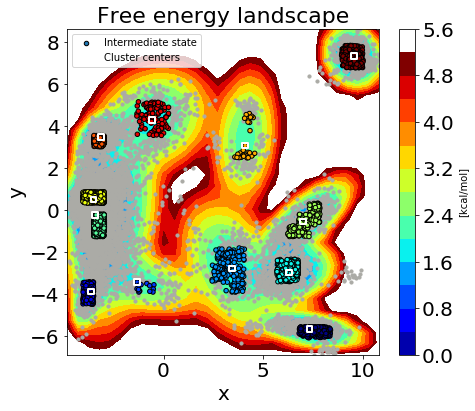

In [13]:
# Visualize free energy landscape with cluster labels
gmm_FE.visualize(savefig=True,vmax=5,show_data=True)